### Time to get your hands dirty. SDSS Galaxies vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new in computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [ ]:
# LECTURE 19: CLASSIFICATION -> Quasars vs Galaxies with generative classification

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd # to read data
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict

In [2]:
df = pd.read_csv("galaxyquasar.csv")
print(df)

# u, g, r, i, z are filters -> use the difference between them 
a = df["u"]-df["g"].to_numpy() 
b = df["g"]-df["r"].to_numpy() 
c = df["r"]-df["i"].to_numpy() 
d = df["i"]-df["z"].to_numpy() 

# matrix
X = np.column_stack((a, b, c, d))

# class vector with QSO = 1 and GALAXY = 0
labels=[]
for i in df["class"]:
    if (i == "QSO"):
        labels.append(1)
    else:
        labels.append(0)

# train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2, random_state = 42)


              u         g         r         i         z   class        z1  \
0      18.97213  18.53676  18.58280  18.34936  18.29215     QSO  0.522819   
1      19.24592  17.47646  16.47817  16.04472  15.68851  GALAXY  0.122846   
2      19.43536  17.70268  16.91565  16.58327  16.39128  GALAXY  0.000000   
3      19.31626  18.18312  17.39591  16.94549  16.65395  GALAXY  0.147435   
4      19.28828  19.11188  18.88937  18.80013  18.49183     QSO  2.011455   
...         ...       ...       ...       ...       ...     ...       ...   
49995  19.37295  18.12382  17.39886  16.98503  16.70585  GALAXY  0.113016   
49996  18.52021  16.88262  16.03280  15.56884  15.22454  GALAXY  0.085063   
49997  18.62718  17.30876  16.87371  16.62399  16.42296  GALAXY  0.054429   
49998  19.55140  18.27711  17.62101  17.21947  17.03347  GALAXY  0.112571   
49999  18.80772  17.75751  17.40500  17.21650  17.12295  GALAXY  0.043652   

           zerr  
0      0.000155  
1      0.000028  
2      0.000000  
3  

auc: 0.9754175293542522
accuracy: 0.9739
precision: 0.8961303462321792
recall: 0.9243697478991597


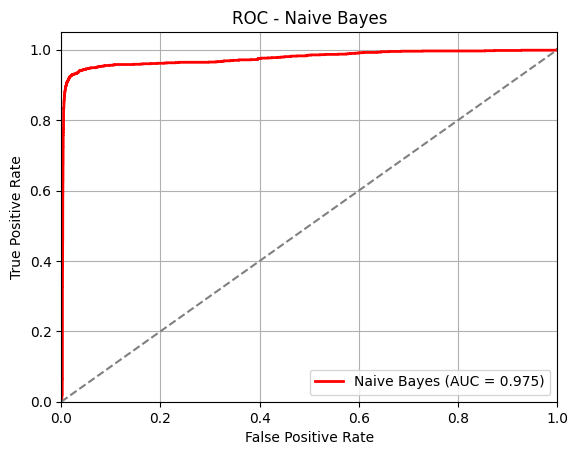

In [3]:
# > NAIVE BAYES
gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_predNB_prob = gnb.predict_proba(x_test)[:, 1] # probability that the given value is a quasar -> use it in the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predNB_prob)
AUC = auc (fpr, tpr)
print(f"auc: {AUC}")

print("accuracy:", metrics.accuracy_score(y_test, y_predNB_prob > 0.5)) 
print("precision:", metrics.precision_score(y_test, y_predNB_prob > 0.5))
print("recall:", metrics.recall_score(y_test, y_predNB_prob > 0.5))
# y_predNB_prob > 0.5 -> convert into binary array (is it a quasar or not)

# ROC 
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'Naive Bayes (AUC = {AUC:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Naive Bayes')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

AUC: 0.980527115185785
accuracy: 0.9808
precision: 0.9395448079658606
recall: 0.9250700280112045


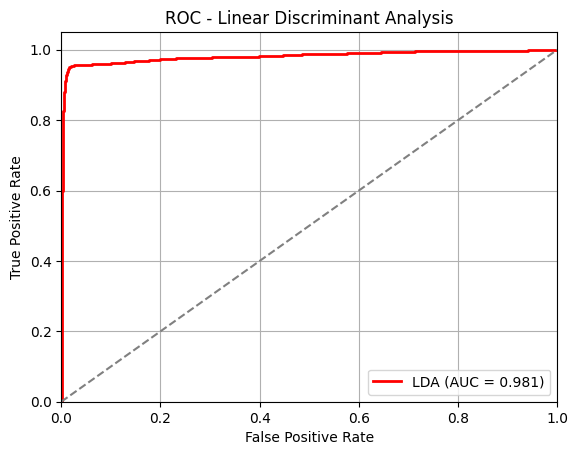

In [4]:
# > LINEAR DISCRIMINANT ANALYSIS
lda = LDA()
lda.fit(x_train, y_train)

y_predLDA_prob = lda.predict_proba(x_test)[:, 1] # probability that the given value is a quasar -> use it in the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predLDA_prob)
AUC_lda = auc (fpr, tpr)
print(f"AUC: {AUC_lda}")

print("accuracy:", metrics.accuracy_score(y_test, y_predLDA_prob > 0.5)) 
print("precision:", metrics.precision_score(y_test, y_predLDA_prob > 0.5))
print("recall:", metrics.recall_score(y_test, y_predLDA_prob > 0.5))

# ROC 
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'LDA (AUC = {AUC_lda:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Linear Discriminant Analysis')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

AUC: 0.980527115185785
accuracy: 0.9808
precision: 0.9395448079658606
recall: 0.9250700280112045


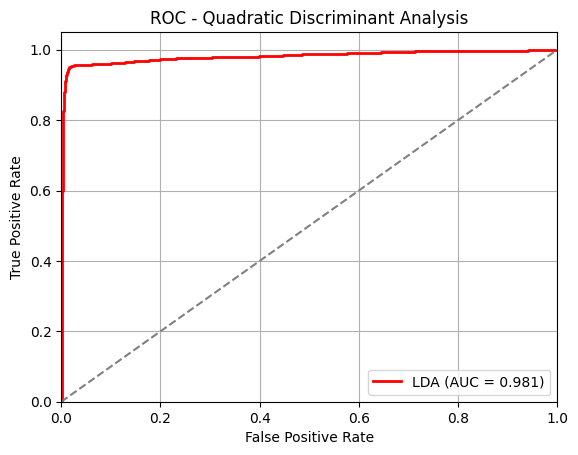

In [5]:
# > QUADRATIC DISCRIMINANT ANALYSIS
qda = QDA()
qda.fit(x_train, y_train)

y_predQDA_prob = lda.predict_proba(x_test)[:, 1] # probability that the given value is a quasar -> use it in the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predQDA_prob)
AUC_qda = auc (fpr, tpr)
print(f"AUC: {AUC_qda}")

print("accuracy:", metrics.accuracy_score(y_test, y_predQDA_prob > 0.5)) 
print("precision:", metrics.precision_score(y_test, y_predQDA_prob > 0.5))
print("recall:", metrics.recall_score(y_test, y_predQDA_prob > 0.5))

# ROC 
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'LDA (AUC = {AUC_qda:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Quadratic Discriminant Analysis')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Max accuracy score is for k=12
AUC: 0.9838
Accuracy: 0.9849
Precision: 0.9597
Recall: 0.9335


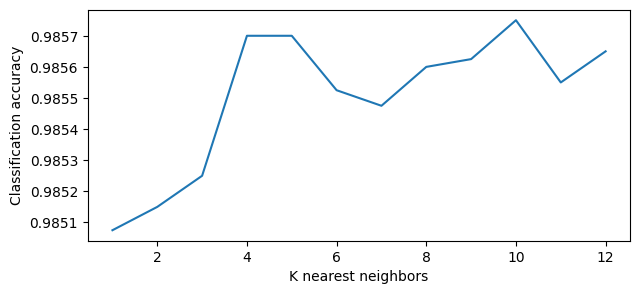

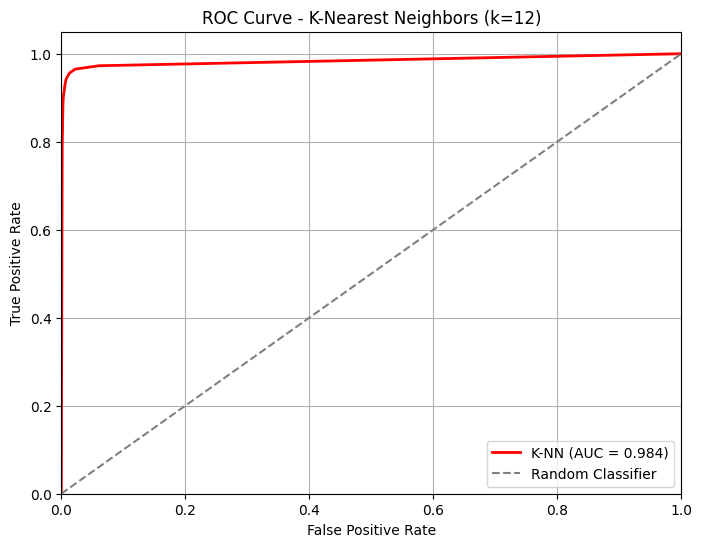

In [6]:
# > K-NEAREST NEIGHBORS
score = []
ks = np.arange(3, 15)

for k in ks:
    KNN = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(KNN, x_train, y_train, cv=5) # cross validation
    score.append(metrics.accuracy_score(y_train, CVpredk))

best_k = ks[np.argmax(score)]
print(f"Max accuracy score is for k={best_k}")

# Plot number of neighbors vs score
fig = plt.figure(figsize=(7, 3))
u = np.arange(len(score))+1
plt.plot(u,score)
plt.xlabel('K nearest neighbors')
plt.ylabel('Classification accuracy')

# Best k-nearest neighbors classifier
KNN_best = KNeighborsClassifier(n_neighbors=best_k)
KNN_best.fit(x_train, y_train)

y_predKNN_prob = KNN_best.predict_proba(x_test)[:, 1] # second column (quasar)

fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test, y_predKNN_prob)
AUC_knn = metrics.auc(fpr_knn, tpr_knn)
print(f"AUC: {AUC_knn:.4f}")

print(f"Accuracy: {metrics.accuracy_score(y_test, y_predKNN_prob>0.5):.4f}")
print(f"Precision: {metrics.precision_score(y_test, y_predKNN_prob>0.5):.4f}")
print(f"Recall: {metrics.recall_score(y_test, y_predKNN_prob>0.5):.4f}")

# ROC 
plt.figure(figsize=(8, 6)) 
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label=f'K-NN (AUC = {AUC_knn:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - K-Nearest Neighbors (k={best_k})')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()